## Sequential failure modes and guardrails
Sequential methods provide error guarantees under assumptions (e.g., i.i.d.-like data, CLT behavior). This notebook shows practical failure modes where those assumptions are violated:

- Drift / non-stationarity: the effect (or baseline) changes over time
- Heavy tails / outliers: normal approximation is fragile
- Early looks too small: unstable variance and noisy z-values

We visualize how these conditions can produce misleading early signals, even with valid sequential mechanics.

Goal:

- Provide an actionable checklist of guardrails to run before trusting sequential outputs.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tecore.sequential.schema import (
    SequentialSpec,
    LookSchedule,
    SequentialConfig,
    SequentialMode,
    SpendingFunction,
    EffectDirection,
)
from tecore.sequential.preprocess import build_look_table_mean
from tecore.sequential.group_sequential import run_group_sequential
from tecore.sequential.confidence_sequences import run_confidence_sequence
from tecore.sequential.simulate import SequentialSimConfig, simulate_ab_stream

plt.rcParams["figure.figsize"] = (9, 5)
plt.rcParams["axes.grid"] = True

spec = SequentialSpec(group_col="group", control_label="control", test_label="test", y_col="y", timestamp_col="timestamp")

## Helper: run and plot a scenario

In [3]:
def run_and_plot_scenario(title, sim_cfg, looks, alpha=0.05, mode="cs"):
    schedule = LookSchedule(looks=looks)

    if mode == "gs":
        cfg = SequentialConfig(
            mode=SequentialMode.GROUP_SEQUENTIAL,
            alpha=alpha,
            two_sided=True,
            spending=SpendingFunction.OBRIEN_FLEMING,
            effect_direction=EffectDirection.TWO_SIDED,
            min_n_per_group=50,
            var_floor=1e-12,
        )
    else:
        cfg = SequentialConfig(
            mode=SequentialMode.CONFIDENCE_SEQUENCE,
            alpha=alpha,
            two_sided=True,
            effect_direction=EffectDirection.TWO_SIDED,
            min_n_per_group=50,
            var_floor=1e-12,
        )

    df = simulate_ab_stream(sim_cfg)
    lt, warn = build_look_table_mean(df, spec, schedule, cfg)
    res = run_group_sequential(lt, cfg) if mode == "gs" else run_confidence_sequence(lt, cfg)

    tab = res.look_table
    x = tab["look_n"].to_numpy(dtype=int)
    z = tab["z"].to_numpy(dtype=float)
    b = pd.to_numeric(tab.get("boundary_z"), errors="coerce").to_numpy(dtype=float)
    est = tab["diff"].to_numpy(dtype=float)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(x, z, marker="o", label="z")
    ax.plot(x, b, linestyle="--", label="boundary")
    ax.plot(x, -b, linestyle="--")
    ax.axhline(0.0, linewidth=1.0)
    ax.set_title(f"{title}: z vs boundary")
    ax.set_xlabel("look_n")
    ax.set_ylabel("z")
    ax.legend(loc="best")
    plt.show()

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(x, est, marker="o", label="estimate (diff)")
    ax.axhline(0.0, linewidth=1.0)
    ax.set_title(f"{title}: effect estimate trajectory")
    ax.set_xlabel("look_n")
    ax.set_ylabel("difference in means")
    ax.legend(loc="best")
    plt.show()

    return res, warn

## 1) Drift / non-stationarity
Even under the null average effect, drift in the data-generating process can create transient signals.

Decision: continue stopped= False stop_look= None


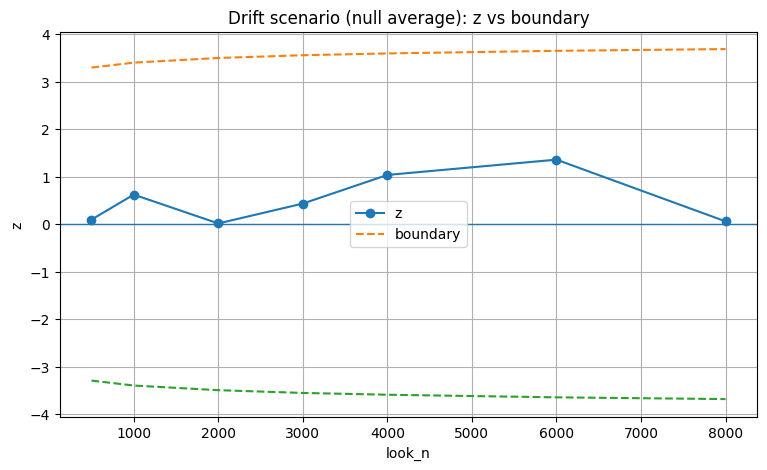

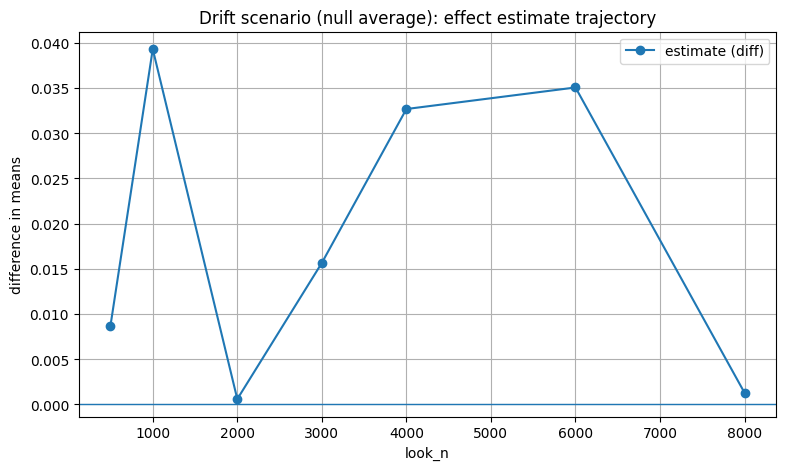

In [4]:
looks = [500, 1000, 2000, 3000, 4000, 6000, 8000]

res_drift, warn_drift = run_and_plot_scenario(
    title="Drift scenario (null average)",
    sim_cfg=SequentialSimConfig(n=8000, effect=0.0, noise_sd=1.0, heavy_tail=False, drift=True, seed=501, ratio=False),
    looks=looks,
    alpha=0.05,
    mode="cs",
)

print("Decision:", res_drift.decision, "stopped=", res_drift.stopped, "stop_look=", res_drift.stop_look)

## 2) Heavy tails / outliers
Heavy-tailed outcomes can break normal approximation and create extreme z-values.

Decision: continue stopped= False stop_look= None


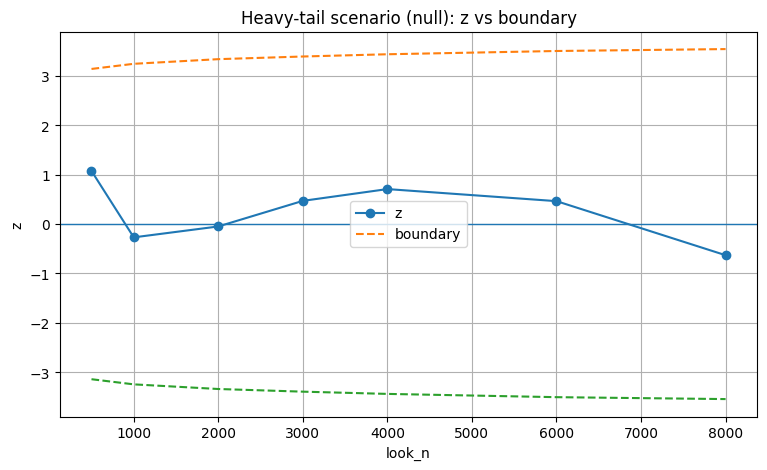

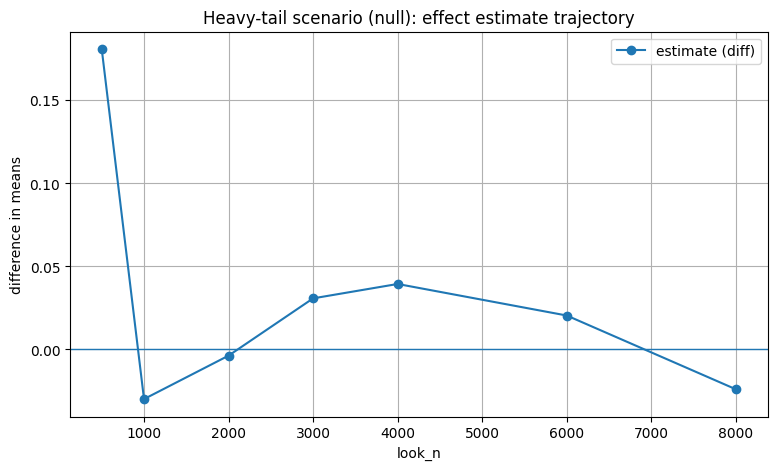

In [5]:
res_ht, warn_ht = run_and_plot_scenario(
    title="Heavy-tail scenario (null)",
    sim_cfg=SequentialSimConfig(n=8000, effect=0.0, noise_sd=1.0, heavy_tail=True, drift=False, seed=777, ratio=False),
    looks=looks,
    alpha=0.05,
    mode="cs",
)

print("Decision:", res_ht.decision, "stopped=", res_ht.stopped, "stop_look=", res_ht.stop_look)

## 3) Early looks too small
Very small looks yield unstable variance and noisy trajectories. Guardrail: enforce min_n_per_group and choose a schedule that is meaningful.

Warnings: ['look_n=50: n_control=28, n_test=22 < min_n_per_group=50.', 'look_n=100: n_control=51, n_test=49 < min_n_per_group=50.']
Decision: continue stopped= False stop_look= None


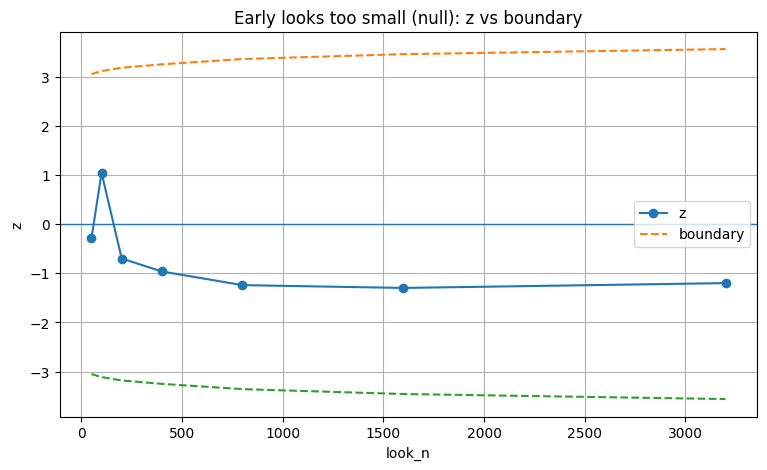

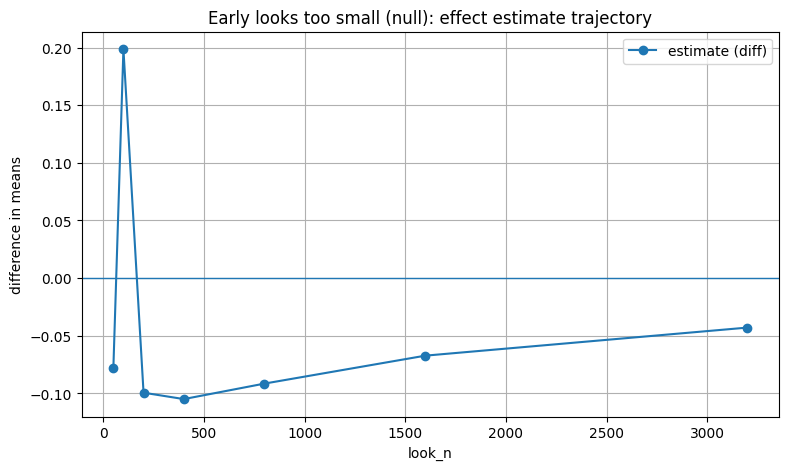

In [6]:
looks_small = [50, 100, 200, 400, 800, 1600, 3200]

res_small, warn_small = run_and_plot_scenario(
    title="Early looks too small (null)",
    sim_cfg=SequentialSimConfig(n=3200, effect=0.0, noise_sd=1.0, heavy_tail=False, drift=False, seed=888, ratio=False),
    looks=looks_small,
    alpha=0.05,
    mode="cs",
)

print("Warnings:", warn_small)
print("Decision:", res_small.decision, "stopped=", res_small.stopped, "stop_look=", res_small.stop_look)

## 4) Quick Monte Carlo: false positives under violations
We compare empirical rejection rates under:

- i.i.d. null (baseline)
- drift null
- heavy-tail null

This is not a theorem; it is a practical diagnostic demonstration.

Empirical rejection rate (iid null): 0.005
Empirical rejection rate (drift null): 0.005
Empirical rejection rate (heavy-tail null): 0.005


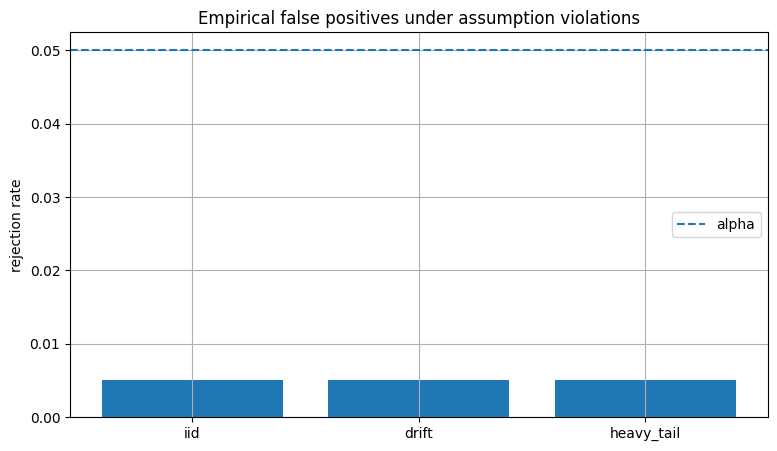

In [7]:
n_sims = 200
N = 8000
looks = [800, 1600, 2400, 3200, 4000, 6000, 8000]
alpha = 0.05

schedule = LookSchedule(looks=looks)
cfg_cs = SequentialConfig(
    mode=SequentialMode.CONFIDENCE_SEQUENCE,
    alpha=alpha,
    two_sided=True,
    effect_direction=EffectDirection.TWO_SIDED,
    min_n_per_group=50,
    var_floor=1e-12,
)

def rej_rate(sim_kwargs):
    rej = []
    for s in range(n_sims):
        df = simulate_ab_stream(SequentialSimConfig(n=N, effect=0.0, noise_sd=1.0, ratio=False, seed=9000 + s, **sim_kwargs))
        lt, _ = build_look_table_mean(df, spec, schedule, cfg_cs)
        res = run_confidence_sequence(lt, cfg_cs)
        rej.append(res.decision == "reject")
    return float(np.mean(rej))

rate_iid = rej_rate({"heavy_tail": False, "drift": False})
rate_drift = rej_rate({"heavy_tail": False, "drift": True})
rate_ht = rej_rate({"heavy_tail": True, "drift": False})

print("Empirical rejection rate (iid null):", rate_iid)
print("Empirical rejection rate (drift null):", rate_drift)
print("Empirical rejection rate (heavy-tail null):", rate_ht)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(["iid", "drift", "heavy_tail"], [rate_iid, rate_drift, rate_ht])
ax.axhline(alpha, linestyle="--", label="alpha")
ax.set_title("Empirical false positives under assumption violations")
ax.set_ylabel("rejection rate")
ax.legend(loc="best")
plt.show()

## Guardrails checklist
Before trusting a sequential decision:

1. Schedule sanity
- Ensure each look has sufficient sample: min_n_per_group is met.
- Avoid very early looks unless you explicitly need them.

2. Outcome diagnostics
- Outliers / heavy tails: consider robustification (winsorization) and rerun sensitivity.
- Variance collapse: ensure var_floor is not masking a data issue.

3. Non-stationarity / drift
- Plot metric over time; check for step changes unrelated to treatment.
- Use pre-period checks and sanity metrics.

4. Experiment health
- Group balance, missingness, logging integrity.
- (Optional) SRM checks where applicable.

## Result summary

We stress-tested the sequential monitoring pipeline under three scenarios:

- **i.i.d. (baseline)**: independent, stable distribution
- **drift**: a non-stationary stream (time trend / seasonality proxy)
- **heavy tails**: higher outlier probability (CLT approximation becomes weaker)

Configuration:
- Two-sided α = 0.05
- Look schedule (K = 7): `[800, 1600, 2400, 3200, 4000, 6000, 8000]`

Empirical false positive rates under the null (Monte Carlo):
- i.i.d.: **0.005**
- drift: **0.005**
- heavy tails: **0.005**

Interpretation:
- In this configuration, the sequential procedure is **highly conservative**: the observed type I error is ~0.5% versus nominal 5% in all tested scenarios.
- The conservativeness appears robust across these stress tests; however, this should be understood as a **trade-off**: lower false positives typically come at the cost of **reduced sensitivity** (later stopping and lower power for small effects).

Practical guardrails (recommended for production):
- Treat sequential conclusions as reliable only when basic diagnostics pass: sufficient per-group sample sizes at each look, stable variance (no near-zero denominators/variance floors), and no strong evidence of sample ratio mismatch.
- For drift / seasonality risk: prefer designs with time-bucketing or pre-specified windows, and monitor covariate balance over time.
- For heavy tails: consider robustification (winsorization/trimmed means) and ensure the metric definition is stable under outliers.

Key takeaway:
- The sequential implementation provides safe monitoring and appears conservative across common failure modes. For production use, apply guardrails and be aware of the power/latency trade-off inherent to conservative anytime-valid boundaries.